In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from transformers import BertTokenizer, BertForQuestionAnswering, BertConfig

from captum.attr import visualization as viz
from captum.attr import LayerConductance, LayerIntegratedGradients
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# replace <PATd:/spofrte/modeH-TO-SAVED-MODEL> with the real path of the saved model
model_path = 'bert-large-uncased-whole-word-masking-finetuned-squad'

# load model
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
model.to(device)
model.eval()
model.zero_grad()

# load tokenizer
tokenizer = BertTokenizer.from_pretrained(model_path)
def predict(inputs, token_type_ids=None, position_ids=None, attention_mask=None):
    output = model(inputs, token_type_ids=token_type_ids,
                 position_ids=position_ids, attention_mask=attention_mask, )
    return output.start_logits, output.end_logits

def squad_pos_forward_func(inputs, token_type_ids=None, position_ids=None, attention_mask=None, position=0):
    pred = predict(inputs,
                   token_type_ids=token_type_ids,
                   position_ids=position_ids,
                   attention_mask=attention_mask)
    pred = pred[position]
    return pred.max(1).values

ref_token_id = tokenizer.pad_token_id # A token used for generating token reference
sep_token_id = tokenizer.sep_token_id # A token used as a separator between question and text and it is also added to the end of the text.
cls_token_id = tokenizer.cls_token_id # A token used for prepending to the concatenated question-text word sequence
def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    return attributions

def construct_input_ref_pair(question, text, ref_token_id, sep_token_id, cls_token_id):
    question_ids = tokenizer.encode(question, add_special_tokens=False)
    text_ids = tokenizer.encode(text, add_special_tokens=False)

    # construct input token ids
    input_ids = [cls_token_id] + question_ids + [sep_token_id] + text_ids + [sep_token_id]

    # construct reference token ids
    ref_input_ids = [cls_token_id] + [ref_token_id] * len(question_ids) + [sep_token_id] + \
                    [ref_token_id] * len(text_ids) + [sep_token_id]

    return torch.tensor([input_ids], device=device), torch.tensor([ref_input_ids], device=device), len(question_ids)


def construct_input_ref_token_type_pair(input_ids, sep_ind=0):
    seq_len = input_ids.size(1)
    token_type_ids = torch.tensor([[0 if i <= sep_ind else 1 for i in range(seq_len)]], device=device)
    ref_token_type_ids = torch.zeros_like(token_type_ids, device=device)  # * -1
    return token_type_ids, ref_token_type_ids


def construct_input_ref_pos_id_pair(input_ids):
    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype=torch.long, device=device)
    # we could potentially also use random permutation with `torch.randperm(seq_length, device=device)`
    ref_position_ids = torch.zeros(seq_length, dtype=torch.long, device=device)

    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
    ref_position_ids = ref_position_ids.unsqueeze(0).expand_as(input_ids)
    return position_ids, ref_position_ids


def construct_attention_mask(input_ids):
    return torch.ones_like(input_ids)


def construct_whole_bert_embeddings(input_ids, ref_input_ids, \
                                    token_type_ids=None, ref_token_type_ids=None, \
                                    position_ids=None, ref_position_ids=None):
    input_embeddings = model.bert.embeddings(input_ids, token_type_ids=token_type_ids, position_ids=position_ids)
    ref_input_embeddings = model.bert.embeddings(ref_input_ids, token_type_ids=token_type_ids,
                                                 position_ids=position_ids)

    return input_embeddings, ref_input_embeddings
def predict_qt(question, text):

    input_ids, ref_input_ids, sep_id = construct_input_ref_pair(question, text, ref_token_id, sep_token_id, cls_token_id)
    token_type_ids, ref_token_type_ids = construct_input_ref_token_type_pair(input_ids, sep_id)
    position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
    attention_mask = construct_attention_mask(input_ids)

    indices = input_ids[0].detach().tolist()
    all_tokens = tokenizer.convert_ids_to_tokens(indices)

    ground_truth = '13'


    start_scores, end_scores = predict(input_ids, \
                                       token_type_ids=token_type_ids, \
                                       position_ids=position_ids, \
                                       attention_mask=attention_mask)


    print('Question: ', question)
    print('Predicted Answer: ', ' '.join(all_tokens[torch.argmax(start_scores) : torch.argmax(end_scores)+1]))
    return input_ids, ref_input_ids, token_type_ids, position_ids, attention_mask, start_scores, end_scores, ground_truth, all_tokens, 

def explain(input_ids, ref_input_ids, token_type_ids, position_ids, attention_mask, start_scores, end_scores, ground_truth, all_tokens, ):
    lig = LayerIntegratedGradients(squad_pos_forward_func, model.bert.embeddings)

    attributions_start, delta_start = lig.attribute(inputs=input_ids,
                                                    baselines=ref_input_ids,
                                                    additional_forward_args=(
                                                    token_type_ids, position_ids, attention_mask, 0),
                                                    return_convergence_delta=True)
    attributions_end, delta_end = lig.attribute(inputs=input_ids, baselines=ref_input_ids,
                                                additional_forward_args=(
                                                token_type_ids, position_ids, attention_mask, 1),
                                                return_convergence_delta=True)

    attributions_start_sum = summarize_attributions(attributions_start)
    attributions_end_sum = summarize_attributions(attributions_end)
    # storing couple samples in an array for visualization purposes
    start_position_vis = viz.VisualizationDataRecord(
        attributions_start_sum,
        torch.max(torch.softmax(start_scores[0], dim=0)),
        torch.argmax(start_scores),
        torch.argmax(start_scores),
        str(ground_truth),
        attributions_start_sum.sum(),
        all_tokens,
        delta_start)

    end_position_vis = viz.VisualizationDataRecord(
        attributions_end_sum,
        torch.max(torch.softmax(end_scores[0], dim=0)),
        torch.argmax(end_scores),
        torch.argmax(end_scores),
        str(ground_truth),
        attributions_end_sum.sum(),
        all_tokens,
        delta_end)
    print(all_tokens)
    print('\033[1m', 'Visualizations For Start Position', '\033[0m')
    viz.visualize_text([start_position_vis])

    print('\033[1m', 'Visualizations For End Position', '\033[0m')

    print("attributions_start_sum:   ", len(attributions_start_sum))
    print("all tokens:    ", len(all_tokens))
    
    return all_tokens, attributions_start_sum

def get_posneg(all_tokens, attributions_start_sum):
    
    positive=[]
    negative=[]
    neutral = []
    for i,j in enumerate(attributions_start_sum):
        if j>0:
            positive.append(i)
            #print('positive:',j)
    ##print(all_tokens[i])
        elif j < 0:
            negative.append(i)
            #print('negative:',j)
            #print(all_tokens[i])
        elif j ==0:
            neutral.append(i)

    s_pos=''
    s_neg=''

    #print(len(attributions_start_sum))
    #print(len(positive))
    #print(len(negative))

    for i in positive:
        s_pos+=all_tokens[i]+' '
    print("positive :" , s_pos)
    for i in negative:
        s_neg+=all_tokens[i]+' '
    print("negative :" , s_neg)
    return positive, negative, neutral

def separate_sentence(all_tokens):
    sentence = {}
    temp = []
    num = 0
    for i in range(len(all_tokens)):
        if all_tokens[i] == "," or all_tokens[i] == ".":
            temp.append(all_tokens[i])
            sentence[num] = temp
            temp = []
            num = num +1
        elif all_tokens[i] == "[CLS]" :
            temp.append(all_tokens[i])
            sentence[num] = temp
            temp = []
            num = num +1
        elif all_tokens[i] == "[SEP]":
            sentence[num] = temp
            num = num +1
            temp = [all_tokens[i]]
            sentence[num] = temp
            temp = []
            num = num +1
        else:
            temp.append(all_tokens[i])
    return sentence  
def get_delete(sentence):
    weight = 0
    sum_weight = 0
    sentence_value=[]
    delete_sentence = []
    for k,v in sentence.items():
        #print(k,':',v)
        for i in v:
            sentence_value.append(i)
    print(sentence_value)
    scores={}
    #print(attributions_start_sum[0].item())

    for i in range(len(attributions_start_sum)):
        try:
            scores[sentence_value[i]]=attributions_start_sum[i].item()
        except:
            pass


    for i, j in sentence.items():
        sum_weight = 0
        for word in j:
            weight = 0

            sum_weight +=  scores[word]
        if sum_weight <= 0:
            delete_sentence.append(i)
    return delete_sentence

def delete_sentence(sentence, li_delete_sentence):
    for i, j in sentence.items():
        if i in li_delete_sentence:
            sentence[i] = []
        else:
            pass
    return sentence
def rebuild_sentence(ori_sentence):
    rebuild_str = ""
    for i, j in ori_sentence.items():
        for word in j:
            rebuild_str += word 
            rebuild_str += " "
    return rebuild_str
def pred_explain(question, text):
    input_ids, ref_input_ids, token_type_ids, position_ids, attention_mask, start_scores, end_scores, ground_truth , all_tokens,  = predict_qt(text, question)

    all_tokens, attributions_start_sum = explain(input_ids, ref_input_ids, token_type_ids, position_ids, attention_mask, start_scores, end_scores, ground_truth, all_tokens, )
    
    return all_tokens, attributions_start_sum

    

In [2]:
question = "who made the history"
text= "At the age of just 13, Japan's Momiji Nishiya made history on Monday by winning the first-ever Olympic gold medal in women's street skateboarding at the Games in Tokyo.  Nishiya topped a youthful podium with Rayssa Leal of Brazil, also 13, taking the silver medal and Japan Funa Nakayama, 16, winning bronze. With an average age of 14 years and 191 days it is the youngest individual podium in the history of the Olympic Games."

all_tokens, attributions_start_sum = pred_explain(text, question)

Question:  who made the history
Predicted Answer:  mom ##iji ni ##shi ##ya
['[CLS]', 'who', 'made', 'the', 'history', '[SEP]', 'at', 'the', 'age', 'of', 'just', '13', ',', 'japan', "'", 's', 'mom', '##iji', 'ni', '##shi', '##ya', 'made', 'history', 'on', 'monday', 'by', 'winning', 'the', 'first', '-', 'ever', 'olympic', 'gold', 'medal', 'in', 'women', "'", 's', 'street', 'skate', '##boarding', 'at', 'the', 'games', 'in', 'tokyo', '.', 'ni', '##shi', '##ya', 'topped', 'a', 'youthful', 'podium', 'with', 'rays', '##sa', 'lea', '##l', 'of', 'brazil', ',', 'also', '13', ',', 'taking', 'the', 'silver', 'medal', 'and', 'japan', 'fun', '##a', 'nak', '##aya', '##ma', ',', '16', ',', 'winning', 'bronze', '.', 'with', 'an', 'average', 'age', 'of', '14', 'years', 'and', '191', 'days', 'it', 'is', 'the', 'youngest', 'individual', 'podium', 'in', 'the', 'history', 'of', 'the', 'olympic', 'games', '.', '[SEP]']
 Visualizations For Start Position 


 Visualizations For End Position 
attributions_start_sum:    107
all tokens:     107


In [3]:
sentence = separate_sentence(all_tokens)
li_delete_sentence = get_delete(sentence)
pro_sentence = delete_sentence(sentence, li_delete_sentence)
print("before\r\n",)
print(text)
print("after\r\n",)
pro_sentence = delete_sentence(sentence, li_delete_sentence)
for i, j in pro_sentence.items():
    print(i, j)

print("delete are", li_delete_sentence)

print("rebuild are: \r\n", )
print(rebuild_sentence(sentence))

['[CLS]', 'who', 'made', 'the', 'history', '[SEP]', 'at', 'the', 'age', 'of', 'just', '13', ',', 'japan', "'", 's', 'mom', '##iji', 'ni', '##shi', '##ya', 'made', 'history', 'on', 'monday', 'by', 'winning', 'the', 'first', '-', 'ever', 'olympic', 'gold', 'medal', 'in', 'women', "'", 's', 'street', 'skate', '##boarding', 'at', 'the', 'games', 'in', 'tokyo', '.', 'ni', '##shi', '##ya', 'topped', 'a', 'youthful', 'podium', 'with', 'rays', '##sa', 'lea', '##l', 'of', 'brazil', ',', 'also', '13', ',', 'taking', 'the', 'silver', 'medal', 'and', 'japan', 'fun', '##a', 'nak', '##aya', '##ma', ',', '16', ',', 'winning', 'bronze', '.', 'with', 'an', 'average', 'age', 'of', '14', 'years', 'and', '191', 'days', 'it', 'is', 'the', 'youngest', 'individual', 'podium', 'in', 'the', 'history', 'of', 'the', 'olympic', 'games', '.', '[SEP]']
before

At the age of just 13, Japan's Momiji Nishiya made history on Monday by winning the first-ever Olympic gold medal in women's street skateboarding at the Game

In [4]:
text=rebuild_sentence(sentence)
text = text[len(question):len(text)]
all_tokens, attributions_start_sum = pred_explain(text, question)

Question:  who made the history
Predicted Answer:  ni # # shi # # ya
['[CLS]', 'who', 'made', 'the', 'history', '[SEP]', 'japan', "'", 's', 'mom', '#', '#', 'i', '##ji', 'ni', '#', '#', 'shi', '#', '#', 'ya', 'made', 'history', 'on', 'monday', 'by', 'winning', 'the', 'first', '-', 'ever', 'olympic', 'gold', 'medal', 'in', 'women', "'", 's', 'street', 'skate', '#', '#', 'boarding', 'at', 'the', 'games', 'in', 'tokyo', '.', 'ni', '#', '#', 'shi', '#', '#', 'ya', 'topped', 'a', 'youthful', 'podium', 'with', 'rays', '#', '#', 'sa', 'lea', '#', '#', 'l', 'of', 'brazil', ',', 'also', '13', ',', '16', ',', '[SEP]']
 Visualizations For Start Position 


 Visualizations For End Position 
attributions_start_sum:    78
all tokens:     78


In [5]:
sentence = separate_sentence(all_tokens)
li_delete_sentence = get_delete(sentence)
pro_sentence = delete_sentence(sentence, li_delete_sentence)
print("before\r\n",)
print(text)
print("after\r\n",)
pro_sentence = delete_sentence(sentence, li_delete_sentence)
for i, j in pro_sentence.items():
    print(i, j)

print("delete are", li_delete_sentence)

print("rebuild are: \r\n", )
print(rebuild_sentence(sentence))

['[CLS]', 'who', 'made', 'the', 'history', '[SEP]', 'japan', "'", 's', 'mom', '#', '#', 'i', '##ji', 'ni', '#', '#', 'shi', '#', '#', 'ya', 'made', 'history', 'on', 'monday', 'by', 'winning', 'the', 'first', '-', 'ever', 'olympic', 'gold', 'medal', 'in', 'women', "'", 's', 'street', 'skate', '#', '#', 'boarding', 'at', 'the', 'games', 'in', 'tokyo', '.', 'ni', '#', '#', 'shi', '#', '#', 'ya', 'topped', 'a', 'youthful', 'podium', 'with', 'rays', '#', '#', 'sa', 'lea', '#', '#', 'l', 'of', 'brazil', ',', 'also', '13', ',', '16', ',', '[SEP]']
before

 japan ' s mom ##iji ni ##shi ##ya made history on monday by winning the first - ever olympic gold medal in women ' s street skate ##boarding at the games in tokyo . ni ##shi ##ya topped a youthful podium with rays ##sa lea ##l of brazil , also 13 , 16 , 
after

0 []
1 ['who', 'made', 'the', 'history']
2 []
3 ['japan', "'", 's', 'mom', '#', '#', 'i', '##ji', 'ni', '#', '#', 'shi', '#', '#', 'ya', 'made', 'history', 'on', 'monday', 'by', 'win

In [6]:
text=rebuild_sentence(sentence)
text = text[len(question):len(text)]
all_tokens, attributions_start_sum = pred_explain(text, question)

Question:  who made the history
Predicted Answer:  ni # # shi # # ya
['[CLS]', 'who', 'made', 'the', 'history', '[SEP]', 'japan', "'", 's', 'mom', '#', '#', 'i', '#', '#', 'ji', 'ni', '#', '#', 'shi', '#', '#', 'ya', 'made', 'history', 'on', 'monday', 'by', 'winning', 'the', 'first', '-', 'ever', 'olympic', 'gold', 'medal', 'in', 'women', "'", 's', 'street', 'skate', '#', '#', 'boarding', 'at', 'the', 'games', 'in', 'tokyo', '.', 'ni', '#', '#', 'shi', '#', '#', 'ya', 'topped', 'a', 'youthful', 'podium', 'with', 'rays', '#', '#', 'sa', 'lea', '#', '#', 'l', 'of', 'brazil', ',', '[SEP]']
 Visualizations For Start Position 


 Visualizations For End Position 
attributions_start_sum:    75
all tokens:     75


In [7]:
sentence = separate_sentence(all_tokens)
li_delete_sentence = get_delete(sentence)
pro_sentence = delete_sentence(sentence, li_delete_sentence)
print("before\r\n",)
print(text)
print("after\r\n",)
pro_sentence = delete_sentence(sentence, li_delete_sentence)
for i, j in pro_sentence.items():
    print(i, j)

print("delete are", li_delete_sentence)

print("rebuild are: \r\n", )
print(rebuild_sentence(sentence))

['[CLS]', 'who', 'made', 'the', 'history', '[SEP]', 'japan', "'", 's', 'mom', '#', '#', 'i', '#', '#', 'ji', 'ni', '#', '#', 'shi', '#', '#', 'ya', 'made', 'history', 'on', 'monday', 'by', 'winning', 'the', 'first', '-', 'ever', 'olympic', 'gold', 'medal', 'in', 'women', "'", 's', 'street', 'skate', '#', '#', 'boarding', 'at', 'the', 'games', 'in', 'tokyo', '.', 'ni', '#', '#', 'shi', '#', '#', 'ya', 'topped', 'a', 'youthful', 'podium', 'with', 'rays', '#', '#', 'sa', 'lea', '#', '#', 'l', 'of', 'brazil', ',', '[SEP]']
before

 japan ' s mom # # i ##ji ni # # shi # # ya made history on monday by winning the first - ever olympic gold medal in women ' s street skate # # boarding at the games in tokyo . ni # # shi # # ya topped a youthful podium with rays # # sa lea # # l of brazil , 
after

0 []
1 ['who', 'made', 'the', 'history']
2 []
3 ['japan', "'", 's', 'mom', '#', '#', 'i', '#', '#', 'ji', 'ni', '#', '#', 'shi', '#', '#', 'ya', 'made', 'history', 'on', 'monday', 'by', 'winning', 'th

In [8]:
text=rebuild_sentence(sentence)
text = text[len(question):len(text)]
all_tokens, attributions_start_sum = pred_explain(text, question)

Question:  who made the history
Predicted Answer:  ni # # shi # # ya
['[CLS]', 'who', 'made', 'the', 'history', '[SEP]', 'japan', "'", 's', 'mom', '#', '#', 'i', '#', '#', 'ji', 'ni', '#', '#', 'shi', '#', '#', 'ya', 'made', 'history', 'on', 'monday', 'by', 'winning', 'the', 'first', '-', 'ever', 'olympic', 'gold', 'medal', 'in', 'women', "'", 's', 'street', 'skate', '#', '#', 'boarding', 'at', 'the', 'games', 'in', 'tokyo', '.', 'ni', '#', '#', 'shi', '#', '#', 'ya', 'topped', 'a', 'youthful', 'podium', 'with', 'rays', '#', '#', 'sa', 'lea', '#', '#', 'l', 'of', 'brazil', ',', '[SEP]']
 Visualizations For Start Position 


 Visualizations For End Position 
attributions_start_sum:    75
all tokens:     75


In [9]:
sentence = separate_sentence(all_tokens)
li_delete_sentence = get_delete(sentence)
pro_sentence = delete_sentence(sentence, li_delete_sentence)
print("before\r\n",)
print(text)
print("after\r\n",)
pro_sentence = delete_sentence(sentence, li_delete_sentence)
for i, j in pro_sentence.items():
    print(i, j)

print("delete are", li_delete_sentence)

print("rebuild are: \r\n", )
print(rebuild_sentence(sentence))

['[CLS]', 'who', 'made', 'the', 'history', '[SEP]', 'japan', "'", 's', 'mom', '#', '#', 'i', '#', '#', 'ji', 'ni', '#', '#', 'shi', '#', '#', 'ya', 'made', 'history', 'on', 'monday', 'by', 'winning', 'the', 'first', '-', 'ever', 'olympic', 'gold', 'medal', 'in', 'women', "'", 's', 'street', 'skate', '#', '#', 'boarding', 'at', 'the', 'games', 'in', 'tokyo', '.', 'ni', '#', '#', 'shi', '#', '#', 'ya', 'topped', 'a', 'youthful', 'podium', 'with', 'rays', '#', '#', 'sa', 'lea', '#', '#', 'l', 'of', 'brazil', ',', '[SEP]']
before

 japan ' s mom # # i # # ji ni # # shi # # ya made history on monday by winning the first - ever olympic gold medal in women ' s street skate # # boarding at the games in tokyo . ni # # shi # # ya topped a youthful podium with rays # # sa lea # # l of brazil , 
after

0 []
1 ['who', 'made', 'the', 'history']
2 []
3 ['japan', "'", 's', 'mom', '#', '#', 'i', '#', '#', 'ji', 'ni', '#', '#', 'shi', '#', '#', 'ya', 'made', 'history', 'on', 'monday', 'by', 'winning', '

In [10]:
text="japan ' s mom # # i # # ji ni # # shi # # ya made history on monday by winning the first - ever olympic gold medal in women ' s street skate # # boarding at the games in tokyo . ni # # shi # # ya topped a youthful podium with rays [UNK] [UNK] [UNK] lea # # l of brazil ,"
text = text[len(question):len(text)]
all_tokens, attributions_start_sum = pred_explain(text, question)

Question:  who made the history
Predicted Answer:  ni # # shi # # ya
['[CLS]', 'who', 'made', 'the', 'history', '[SEP]', '#', '#', 'ji', 'ni', '#', '#', 'shi', '#', '#', 'ya', 'made', 'history', 'on', 'monday', 'by', 'winning', 'the', 'first', '-', 'ever', 'olympic', 'gold', 'medal', 'in', 'women', "'", 's', 'street', 'skate', '#', '#', 'boarding', 'at', 'the', 'games', 'in', 'tokyo', '.', 'ni', '#', '#', 'shi', '#', '#', 'ya', 'topped', 'a', 'youthful', 'podium', 'with', 'rays', '[UNK]', '[UNK]', '[UNK]', 'lea', '#', '#', 'l', 'of', 'brazil', ',', '[SEP]']
 Visualizations For Start Position 


 Visualizations For End Position 
attributions_start_sum:    68
all tokens:     68


In [11]:
text="japan ' s mom # # i # # ji ni # # shi # # ya made history on [UNK] by [UNK] the first - ever olympic gold medal in women ' s street skate # # boarding at the games in [UNK] . ni # # shi # # ya [UNK] a youthful podium [UNK] rays [UNK] [UNK] [UNK] [UNK] # # l of brazil ,"
text = text[len(question):len(text)]
all_tokens, attributions_start_sum = pred_explain(text, question)

Question:  who made the history
Predicted Answer:  ni # # shi # # ya
['[CLS]', 'who', 'made', 'the', 'history', '[SEP]', '#', '#', 'ji', 'ni', '#', '#', 'shi', '#', '#', 'ya', 'made', 'history', 'on', '[UNK]', 'by', '[UNK]', 'the', 'first', '-', 'ever', 'olympic', 'gold', 'medal', 'in', 'women', "'", 's', 'street', 'skate', '#', '#', 'boarding', 'at', 'the', 'games', 'in', '[UNK]', '.', 'ni', '#', '#', 'shi', '#', '#', 'ya', '[UNK]', 'a', 'youthful', 'podium', '[UNK]', 'rays', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '#', '#', 'l', 'of', 'brazil', ',', '[SEP]']
 Visualizations For Start Position 


 Visualizations For End Position 
attributions_start_sum:    68
all tokens:     68


In [14]:
text="japan ' s mom # # i # # ji ni # # shi # # ya [UNK] [UNK] on [UNK] by [UNK] the first - ever olympic gold [UNK] in women ' s street skate # # boarding at the games in [UNK] . ni # # shi # # ya [UNK] a youthful podium [UNK] rays [UNK] [UNK] [UNK] [UNK] # # l [UNK] brazil ,"
text = text[len(question):len(text)]
all_tokens, attributions_start_sum = pred_explain(text, question)

Question:  who made the history
Predicted Answer:  ni # # shi # # ya
['[CLS]', 'who', 'made', 'the', 'history', '[SEP]', '#', '#', 'ji', 'ni', '#', '#', 'shi', '#', '#', 'ya', '[UNK]', '[UNK]', 'on', '[UNK]', 'by', '[UNK]', 'the', 'first', '-', 'ever', 'olympic', 'gold', '[UNK]', 'in', 'women', "'", 's', 'street', 'skate', '#', '#', 'boarding', 'at', 'the', 'games', 'in', '[UNK]', '.', 'ni', '#', '#', 'shi', '#', '#', 'ya', '[UNK]', 'a', 'youthful', 'podium', '[UNK]', 'rays', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '#', '#', 'l', '[UNK]', 'brazil', ',', '[SEP]']
 Visualizations For Start Position 


 Visualizations For End Position 
attributions_start_sum:    68
all tokens:     68


In [15]:
positive=[]
negative=[]
for i,j in enumerate(attributions_start_sum):
    if j>0:
        positive.append(i)
        #print('positive:',j)
##print(all_tokens[i])
    elif j < 0:
        negative.append(i)
        #print('negative:',j)
        #print(all_tokens[i])
        
s_pos=''
s_neg=''

#print(len(attributions_start_sum))
#print(len(positive))
#print(len(negative))

for i in positive:
    s_pos+=all_tokens[i]+' '
print("positive :" , s_pos)
for i in negative:
    s_neg+=all_tokens[i]+' '
print("negative :" , s_neg)

positive : the history # on [UNK] the first - ever [UNK] in women ' s street at the games [UNK] . ni # # shi # # [UNK] [UNK] [UNK] # [UNK] 
negative : who made # ji ni # # shi # # ya [UNK] [UNK] [UNK] by olympic gold skate # # boarding in ya a youthful podium rays [UNK] [UNK] [UNK] # l brazil , 


In [16]:
text="japan ' s mom # # i # # ji ni # # shi # # ya [UNK] [UNK] on [UNK] [UNK] [UNK] the first - ever [UNK] [UNK] [UNK] [UNK] women ' s street [UNK] # # [UNK] at the games in [UNK] . ni # # shi # # ya [UNK] a [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] # # l [UNK] [UNK] ,"
text = text[len(question):len(text)]
all_tokens, attributions_start_sum = pred_explain(text, question)

Question:  who made the history
Predicted Answer:  # # ji ni # # shi # # ya
['[CLS]', 'who', 'made', 'the', 'history', '[SEP]', '#', '#', 'ji', 'ni', '#', '#', 'shi', '#', '#', 'ya', '[UNK]', '[UNK]', 'on', '[UNK]', '[UNK]', '[UNK]', 'the', 'first', '-', 'ever', '[UNK]', '[UNK]', '[UNK]', '[UNK]', 'women', "'", 's', 'street', '[UNK]', '#', '#', '[UNK]', 'at', 'the', 'games', 'in', '[UNK]', '.', 'ni', '#', '#', 'shi', '#', '#', 'ya', '[UNK]', 'a', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '#', '#', 'l', '[UNK]', '[UNK]', ',', '[SEP]']
 Visualizations For Start Position 


 Visualizations For End Position 
attributions_start_sum:    68
all tokens:     68


In [17]:
positive=[]
negative=[]
for i,j in enumerate(attributions_start_sum):
    if j>0:
        positive.append(i)
        #print('positive:',j)
##print(all_tokens[i])
    elif j < 0:
        negative.append(i)
        #print('negative:',j)
        #print(all_tokens[i])
        
s_pos=''
s_neg=''

#print(len(attributions_start_sum))
#print(len(positive))
#print(len(negative))

for i in positive:
    s_pos+=all_tokens[i]+' '
print("positive :" , s_pos)
for i in negative:
    s_neg+=all_tokens[i]+' '
print("negative :" , s_neg)

positive : who the history # shi on [UNK] [UNK] the first - ever [UNK] [UNK] women ' s street [UNK] [UNK] at the [UNK] ni # shi # # ya [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] # [UNK] [UNK] 
negative : made # ji ni # # # # ya [UNK] [UNK] [UNK] [UNK] [UNK] # # games in . # a [UNK] [UNK] [UNK] # l , 


In [18]:
text="japan ' s mom # # i # # ji ni # # shi # # ya [UNK] [UNK] on [UNK] [UNK] [UNK] the first - ever [UNK] [UNK] [UNK] [UNK] women ' s street [UNK] # # [UNK] at the [UNK] [UNK] [UNK] . ni # # shi # # ya [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] # # [UNK] [UNK] [UNK] ,"
text = text[len(question):len(text)]
all_tokens, attributions_start_sum = pred_explain(text, question)
positive=[]
negative=[]
for i,j in enumerate(attributions_start_sum):
    if j>0:
        positive.append(i)
        #print('positive:',j)
##print(all_tokens[i])
    elif j < 0:
        negative.append(i)
        #print('negative:',j)
        #print(all_tokens[i])
        
s_pos=''
s_neg=''

#print(len(attributions_start_sum))
#print(len(positive))
#print(len(negative))

for i in positive:
    s_pos+=all_tokens[i]+' '
print("positive :" , s_pos)
for i in negative:
    s_neg+=all_tokens[i]+' '
print("negative :" , s_neg)

Question:  who made the history
Predicted Answer:  # # ji ni # # shi # # ya
['[CLS]', 'who', 'made', 'the', 'history', '[SEP]', '#', '#', 'ji', 'ni', '#', '#', 'shi', '#', '#', 'ya', '[UNK]', '[UNK]', 'on', '[UNK]', '[UNK]', '[UNK]', 'the', 'first', '-', 'ever', '[UNK]', '[UNK]', '[UNK]', '[UNK]', 'women', "'", 's', 'street', '[UNK]', '#', '#', '[UNK]', 'at', 'the', '[UNK]', '[UNK]', '[UNK]', '.', 'ni', '#', '#', 'shi', '#', '#', 'ya', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '#', '#', '[UNK]', '[UNK]', '[UNK]', ',', '[SEP]']
 Visualizations For Start Position 


 Visualizations For End Position 
attributions_start_sum:    68
all tokens:     68
positive : who the history [UNK] [UNK] the first - ever [UNK] [UNK] [UNK] [UNK] women ' s street [UNK] [UNK] the [UNK] [UNK] [UNK] . ni # # shi # # ya [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] 
negative : made # # ji ni # # shi # # ya [UNK] [UNK] on [UNK] # # at [UNK] # # , 


[0.83, 0.55, 0.64, 0.64, 0.86, 0.73, 0.26, 0.38, 0.61]


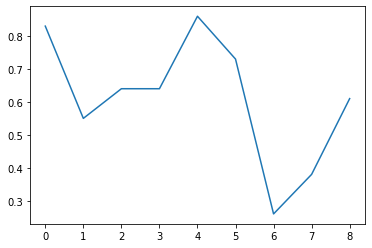

In [1]:
import matplotlib.pyplot as plt
a = [0.83, 0.55, 0.64, 0.64, 0.86, 0.73, 0.26, 0.38, 0.61]
print(a)
plt.plot(range(len(a)), a)
plt.show()